In [3]:
import os

dataset_path = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
print("Can access dataset:", os.access(dataset_path, os.R_OK))


Can access dataset: True


In [2]:
import gzip
import shutil
import os

# Define the folder containing the .nii.gz files
dataset_path = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# List all .nii.gz files
gz_files = [f for f in os.listdir(dataset_path) if f.endswith('.nii.gz')]

for gz_file in gz_files:
    gz_path = os.path.join(dataset_path, gz_file)
    nii_path = gz_path.replace('.gz', '')  # Output filename without .gz

    # Extract .nii file
    with gzip.open(gz_path, 'rb') as f_in:
        with open(nii_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print(f"Extracted: {nii_path}")


Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_label-CSF_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_label-GM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_label-WM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-03_space-MNI152NLin2009cAsym_label-WM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-05_label-CSF_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-05_label-GM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\sub-05_label-WM_probseg.nii
Extracted: C:\Users\goud3\OneDrive\Documents\d

Image shape: (208, 320, 320)


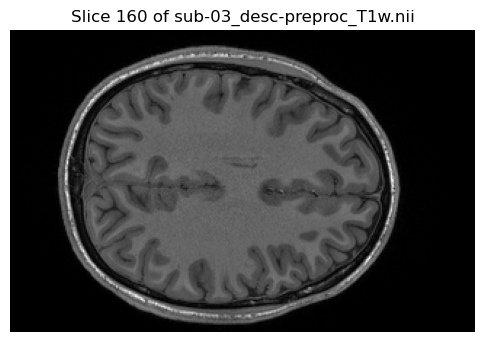

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the dataset path (update if needed)
dataset_path = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# List all extracted .nii files
nii_files = [f for f in os.listdir(dataset_path) if f.endswith('.nii')]

# Load one sample file
sample_file = os.path.join(dataset_path, nii_files[0])  # First file in the list
img = nib.load(sample_file)  # Load NIfTI file
img_data = img.get_fdata()  # Get the actual image data as a NumPy array

# Check shape of the MRI scan (should be 3D)
print(f"Image shape: {img_data.shape}")  # Example: (256, 256, 150)

# Select a middle slice along the z-axis
slice_index = img_data.shape[2] // 2
mri_slice = img_data[:, :, slice_index]  # Extract the middle slice

# Plot the MRI slice
plt.figure(figsize=(6, 6))
plt.imshow(mri_slice, cmap="gray")
plt.title(f"Slice {slice_index} of {nii_files[0]}")
plt.axis("off")
plt.show()


In [5]:
pip install torchvision --no-cache-dir


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 41.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
    --------------------------------------- 3.1/204.2 MB 14.2 MB/s eta 0:00:15
   - -------------------------------------- 5.8/204.2 MB 13.0 MB/s eta 0:00:16
   - -------------------------------------- 7.9/204.2 MB 12.8 MB/s eta 0:00:16
   -- ------------------------------------- 10.5/204.2 MB 12.6 MB/s eta 0:00:16
   -- ------------------------------------- 11.8/204.2 MB 11.2 MB/s eta 0:00:18
   -- ------------------------------------- 14.4/204.2 MB 11.3 MB/s eta 0:00:17
   --- ------------------------------------ 16.8/204.2 MB 11.4 MB/s eta 0:00:17
   --- ------------------------------------ 19.4/204.2 MB 11.3 MB/s eta 0:00:17
   ---- ----------------------------------- 22.0/204.2 MB 11.4 MB/s eta 0:00:16
   ---- ----------------------------------- 24.4/204.2 MB 11.4 MB/

  You can safely remove it manually.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.transform import resize  # For resizing images

class BrainMRI_Dataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(128, 128, 64)):  
        """
        Args:
            data_dir (str): Path to directory containing .nii files.
            transform (callable, optional): Optional transform to apply.
            target_size (tuple): Desired shape (H, W, D) to resize the 3D scans.
        """
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nii')]
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        nii_path = os.path.join(self.data_dir, self.files[idx])
        img = nib.load(nii_path).get_fdata()  # Load the .nii image as a NumPy array
        
        # Normalize: Scale intensities to [0,1]
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8) 
        
        # Resize to uniform shape
        img = resize(img, self.target_size, anti_aliasing=True)  

        # Convert to PyTorch tensor and add a channel dimension (C, H, W, D)
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor  # Returning only image, no label for now

# Set dataset path
dataset_path = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Create dataset
brain_dataset = BrainMRI_Dataset(dataset_path)

# Create DataLoader
train_loader = DataLoader(brain_dataset, batch_size=2, shuffle=True)

# Check dataset size
print(f"✅ Dataset loaded: {len(brain_dataset)} MRI scans")




✅ Dataset loaded: 36 MRI scans


In [13]:
import torch
import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader

class NeuroImagingDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
        
        # Find the maximum shape across all MRI scans
        self.max_shape = self.get_max_shape()

    def get_max_shape(self):
        max_shape = [0, 0, 0]  # [Depth, Height, Width]
        for file in self.file_list:
            file_path = os.path.join(self.data_dir, file)
            img_shape = nib.load(file_path).shape
            max_shape = np.maximum(max_shape, img_shape)  # Element-wise max
        print(f"📏 Max Shape (Padding Target): {max_shape}")
        return tuple(max_shape)

    def pad_image(self, img):
        """Pad image to max_shape with zeros."""
        pad_dims = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(self.max_shape)]
        return np.pad(img, pad_dims, mode='constant', constant_values=0)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)

        # Load MRI scan
        img = nib.load(file_path).get_fdata()

        # Normalize intensity (Min-Max Scaling)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

        # Pad the image to max_shape
        img = self.pad_image(img)

        # Convert to PyTorch tensor
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim

        return img_tensor

# Load dataset
dataset_path = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
mri_dataset = NeuroImagingDataset(dataset_path)
mri_loader = DataLoader(mri_dataset, batch_size=2, shuffle=True)

# Test batch
sample = next(iter(mri_loader))
print(f"✅ Padded Sample MRI scan shape: {sample.shape}")  # Should be (batch, 1, Depth, Height, Width)


📏 Max Shape (Padding Target): [241 320 320]
✅ Padded Sample MRI scan shape: torch.Size([2, 1, 241, 320, 320])


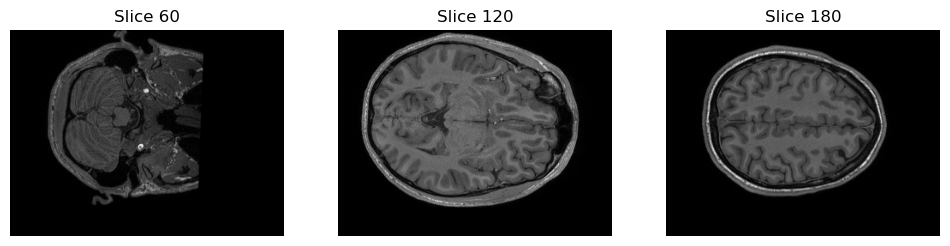

In [14]:
import matplotlib.pyplot as plt

# Select one sample scan
sample_mri = mri_dataset[0].squeeze(0).numpy()  # Remove channel dim

# Choose a few slices to visualize (middle slices)
slice_indices = [60, 120, 180]  # Adjust these indices based on depth

plt.figure(figsize=(12, 4))
for i, idx in enumerate(slice_indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample_mri[:, :, idx], cmap="gray")  # Show slice
    plt.title(f"Slice {idx}")
    plt.axis("off")

plt.show()


In [7]:
pip install monai

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import monai
from monai.networks.nets import UNet

# Define the pre-trained MONAI U-Net
model = UNet(
    spatial_dims=3,  # 3D segmentation
    in_channels=1,   # MRI has 1 channel (grayscale)
    out_channels=1,  # Binary segmentation (brain vs. non-brain)
    channels=(16, 32, 64, 128, 256),  # Encoder channels
    strides=(2, 2, 2, 2),  # Downsampling
).to("cuda" if torch.cuda.is_available() else "cpu")

print("✅ MONAI 3D U-Net Loaded!")


✅ MONAI 3D U-Net Loaded!


In [19]:
import os
import glob
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.config import print_config

print_config()  # Check MONAI version


MONAI version: 1.4.0
Numpy version: 1.26.0
Pytorch version: 2.6.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: C:\Users\<username>\anaconda3\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.15.1
Pillow version: 11.1.0
Tensorboard version: 2.15.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cpu
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

In [37]:
import glob
import os

data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Find all .nii.gz files
image_paths = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))

# Check dataset files
print(f"Total MRI scans found: {len(image_paths)}")
print(image_paths[:5])  # Show first 5 files


Total MRI scans found: 18
['C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-CSF_probseg.nii.gz', 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-GM_probseg.nii.gz', 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-WM_probseg.nii.gz', 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz', 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz']


In [20]:
# Define MONAI transforms for preprocessing
train_transforms = Compose([
    LoadImaged(keys=["image"]),  # Load NIfTI images
    EnsureChannelFirstd(keys=["image"]),  # Convert to channel-first format
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),  # Resample to 1mm spacing
    ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),  # Normalize
    CropForegroundd(keys=["image"], source_key="image"),  # Remove background
    ToTensord(keys=["image"])  # Convert to PyTorch Tensor
])


C:\Users\goud3\anaconda3\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [38]:
# Prepare dataset dictionary
data_dicts = [{"image": img} for img in image_paths]

# Create MONAI Dataset
dataset = Dataset(data=data_dicts, transform=train_transforms)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

print(f"✅ Dataset ready: {len(dataset)} MRI scans")


✅ Dataset ready: 18 MRI scans


Sample MRI scan shape: torch.Size([1, 167, 240, 240])


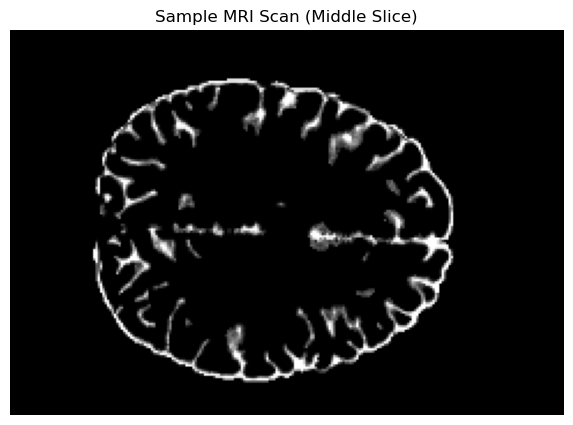

In [22]:
# Get a sample from the dataset
sample = dataset[0]["image"]  # Extract single scan
print(f"Sample MRI scan shape: {sample.shape}")

# Convert to NumPy for visualization
sample_np = sample.squeeze().cpu().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(sample_np[:, :, sample_np.shape[-1] // 2], cmap="gray")  # Show middle slice
plt.title("Sample MRI Scan (Middle Slice)")
plt.axis("off")
plt.show()


In [23]:
import os
import torch
import monai
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, ToTensord
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import Dataset, DataLoader
from torch.optim import Adam

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [39]:
print(f"Total samples found: {len(data_dicts)}")
print(data_dicts[:5])  # Print first 5 file paths


Total samples found: 18
[{'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-CSF_probseg.nii.gz'}, {'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-GM_probseg.nii.gz'}, {'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-WM_probseg.nii.gz'}, {'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'}, {'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz'}]


In [40]:
import os

data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Check if the directory exists
if not os.path.exists(data_dir):
    print("❌ ERROR: Dataset directory does not exist!")
else:
    print("✅ Directory exists. Listing contents...")
    print(os.listdir(data_dir))  # Print folder contents


✅ Directory exists. Listing contents...
['images', 'masks', 'sub-03_desc-preproc_T1w.nii', 'sub-03_dseg.nii', 'sub-03_label-CSF_probseg.nii', 'sub-03_label-CSF_probseg.nii.gz', 'sub-03_label-GM_probseg.nii', 'sub-03_label-GM_probseg.nii.gz', 'sub-03_label-WM_probseg.nii', 'sub-03_label-WM_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii', 'sub-03_space-MNI152NLin2009cAsym_dseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_label-WM_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz', 'sub-05_desc-preproc_T1w.nii', 'sub-05_dseg.nii', 'sub-05_label-CSF_probseg.nii', 'sub-05_label-CSF_probseg.nii.gz', 'sub-05_label-GM_probseg.nii', 'sub-05_label-GM_probseg.nii.gz', 'sub-05_label-WM_probseg.nii', 'sub-05_label-WM_probseg.

In [51]:
import os
import glob

data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Find image and mask files
image_files = sorted(glob.glob(os.path.join(data_dir, "*_desc-preproc_T1w.nii.gz")))
mask_files = sorted(glob.glob(os.path.join(data_dir, "*_dseg.nii.gz")))

print(f"🧠 Found {len(image_files)} MRI images")
print(f"🎭 Found {len(mask_files)} Segmentation masks")

# Print sample files
print("\nSample MRI Images:", image_files[:3])
print("Sample Masks:", mask_files[:3])


🧠 Found 0 MRI images
🎭 Found 0 Segmentation masks

Sample MRI Images: []
Sample Masks: []


In [43]:
print(data_dicts[0])  # Print the first element to check its keys


{'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\sub-03_label-CSF_probseg.nii.gz'}


In [48]:
mask_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks"
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_dseg.nii.gz")))

print(f"🔍 Total Masks Found: {len(mask_paths)}")


🔍 Total Masks Found: 6


In [49]:
print(f"🔍 Total Images Found: {len(image_paths)}")
print(f"🔍 Total Masks Found: {len(mask_paths)}")


🔍 Total Images Found: 6
🔍 Total Masks Found: 6


In [52]:
import os
import glob

# Define the dataset paths
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
image_dir =  r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\images"
mask_dir =  r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks"

# Find all image and mask files
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))

# Ensure equal number of images and masks
assert len(image_paths) == len(mask_paths), "❌ Mismatch: Image and Mask count differs!"

# Create the dataset dictionary
data_dicts = [{"image": img, "mask": msk} for img, msk in zip(image_paths, mask_paths)]

# Debug: Print first entry to verify
print(data_dicts[0])


{'image': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\images\\sub-03_desc-preproc_T1w.nii.gz', 'mask': 'C:\\Users\\goud3\\OneDrive\\Documents\\data\\OpenNeuro_Filtered\\masks\\sub-03_dseg.nii.gz'}


In [53]:
# Check if all images and masks exist
import os

for data in data_dicts:
    assert os.path.exists(data["image"]), f"❌ Missing image: {data['image']}"
    assert os.path.exists(data["mask"]), f"❌ Missing mask: {data['mask']}"

print("✅ All images and masks exist.")


✅ All images and masks exist.


In [55]:
import os
import glob
import nibabel as nib

# Define dataset paths
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
image_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\images"
mask_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks"

# Get all image and mask file paths
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_dseg.nii.gz")))  # Adjust if needed

# Ensure equal number of images and masks
assert len(image_paths) == len(mask_paths), f"❌ Mismatch: {len(image_paths)} images, {len(mask_paths)} masks"

# Load and check first 5 samples
for i in range(5):
    img_path = image_paths[i] if i < len(image_paths) else None
    mask_path = mask_paths[i] if i < len(mask_paths) else None

    img = nib.load(img_path).get_fdata() if img_path else None
    mask = nib.load(mask_path).get_fdata() if mask_path else None

    print(f"🖼️ Image {i}: {img_path}")
    print(f"📏 Image {i} shape: {img.shape if img is not None else '❌ None'}")
    print(f"🎭 Mask {i}: {mask_path}")
    print(f"📏 Mask {i} shape: {mask.shape if mask is not None else '❌ None'}")
    print("-" * 50)


🖼️ Image 0: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\images\sub-03_desc-preproc_T1w.nii.gz
📏 Image 0 shape: (208, 320, 320)
🎭 Mask 0: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks\sub-03_dseg.nii.gz
📏 Mask 0 shape: (208, 320, 320)
--------------------------------------------------
🖼️ Image 1: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\images\sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz
📏 Image 1 shape: (241, 305, 257)
🎭 Mask 1: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks\sub-03_space-MNI152NLin2009cAsym_dseg.nii.gz
📏 Mask 1 shape: (241, 305, 257)
--------------------------------------------------
🖼️ Image 2: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\images\sub-05_desc-preproc_T1w.nii.gz
📏 Image 2 shape: (208, 320, 320)
🎭 Mask 2: C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered\masks\sub-05_dseg.nii.gz
📏 Mask 2 shape: (208, 320, 320)
------------------------------------------------

In [56]:
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd
from monai.transforms import Resize

data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

# Get new file paths
image_files = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))

# Create dictionary
data_dicts = [{"image": img, "mask": msk} for img, msk in zip(image_files, mask_files)]
# Define a target size (Choose based on your dataset)
TARGET_SIZE = (128, 128, 128)  # Adjust as needed

# Define Transforms
from monai.transforms import Resized

train_transforms = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityd(keys=["image"]),
    Resized(keys=["image", "mask"], spatial_size=TARGET_SIZE),  # ✅ Correct version
])


# Create Dataset
dataset = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)  # Use num_workers=0 for Windows

print(f"✅ Dataset ready: {len(dataset)} MRI scans")

✅ Dataset ready: 6 MRI scans


In [57]:
from monai.networks.nets import UNet
import torch

# Define the model
model = UNet(
    spatial_dims=3,   # 3D U-Net
    in_channels=1,    # MRI scans have 1 channel (grayscale)
    out_channels=1,   # Binary segmentation (brain vs. background)
    channels=(16, 32, 64, 128, 256),  # Number of filters at each layer
    strides=(2, 2, 2, 2),  # Downsampling
    num_res_units=2,  # Number of residual units
).to("cuda" if torch.cuda.is_available() else "cpu")

print("✅ Model initialized!")


✅ Model initialized!


In [58]:
from monai.losses import DiceLoss
from torch.optim import Adam

# Loss function
loss_function = DiceLoss(sigmoid=True)

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

print("✅ Loss and optimizer ready!")


✅ Loss and optimizer ready!


In [17]:
pip install ignite


Note: you may need to restart the kernel to use updated packages.


In [59]:
import ignite.handlers
print("Ignite handlers module is available.")


Ignite handlers module is available.


In [60]:
import nibabel as nib
import os
import glob

data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

image_files = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))

size_mismatches = []

for img_path, mask_path in zip(image_files, mask_files):
    img = nib.load(img_path).shape
    mask = nib.load(mask_path).shape

    if img != mask:
        size_mismatches.append((os.path.basename(img_path), img, os.path.basename(mask_path), mask))

if size_mismatches:
    print("❌ Size mismatches found:")
    for img_name, img_size, mask_name, mask_size in size_mismatches:
        print(f"  Image: {img_name} {img_size}  ≠  Mask: {mask_name} {mask_size}")
else:
    print("✅ All image-mask pairs have matching sizes.")


✅ All image-mask pairs have matching sizes.


In [63]:
for i in range(3):
    sample = dataset[i]
    print(f"Image {i} shape: {sample['image'].shape if sample['image'] is not None else '❌ None'}")
    print(f"Mask {i} shape: {sample['mask'].shape if sample['mask'] is not None else '❌ None'}")


Image 0 shape: torch.Size([1, 128, 128, 128])
Mask 0 shape: torch.Size([1, 128, 128, 128])
Image 1 shape: torch.Size([1, 128, 128, 128])
Mask 1 shape: torch.Size([1, 128, 128, 128])
Image 2 shape: torch.Size([1, 128, 128, 128])
Mask 2 shape: torch.Size([1, 128, 128, 128])


In [64]:
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, Resized
import os
import glob

# Set dataset paths
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

# Get file lists
image_files = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))

# Create dictionary
data_dicts = [{"image": img, "mask": msk} for img, msk in zip(image_files, mask_files)]

# Define target size (adjust based on dataset)
TARGET_SIZE = (128, 128, 128)

# Define MONAI transforms
train_transforms = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityd(keys=["image"]),  # Normalize intensity
    Resized(keys=["image", "mask"], spatial_size=TARGET_SIZE),  # Resize to match
])

# Create Dataset & DataLoader
dataset = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)

print(f"✅ Dataset ready: {len(dataset)} MRI scans")


✅ Dataset ready: 6 MRI scans


In [65]:
import torch
import monai
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Training on: {device}")

# Define MONAI's 3D U-Net model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,  # Adjust for multi-class segmentation if needed
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Define loss function & optimizer
loss_function = DiceLoss(sigmoid=True)  # Binary segmentation
optimizer = Adam(model.parameters(), lr=1e-4)


✅ Training on: cpu


In [69]:
train_ds = dataset  # Assign dataset to train_ds

# Check first 3 samples
for i in range(3):
    img, mask = train_ds[i]["image"], train_ds[i]["mask"]
    print(f"Sample {i}: Image shape: {img.shape}, Mask shape: {mask.shape}")


Sample 0: Image shape: torch.Size([1, 128, 128, 128]), Mask shape: torch.Size([1, 128, 128, 128])
Sample 1: Image shape: torch.Size([1, 128, 128, 128]), Mask shape: torch.Size([1, 128, 128, 128])
Sample 2: Image shape: torch.Size([1, 128, 128, 128]), Mask shape: torch.Size([1, 128, 128, 128])


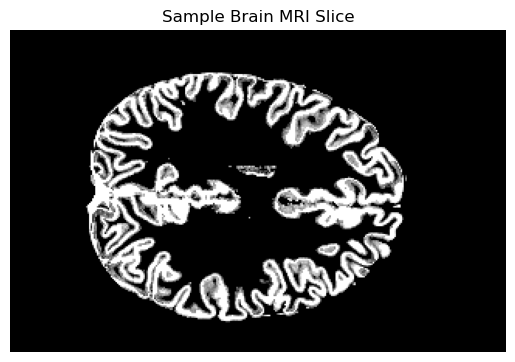

In [5]:
import os
import nibabel as nib
import numpy as np
import torch
import monai
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, ToTensord
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt

# Path to your OpenNeuro dataset
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Load a sample NIfTI image
sample_image_path = os.path.join(data_dir, "sub-03_label-GM_probseg.nii")
img_nib = nib.load(sample_image_path)
img_data = img_nib.get_fdata()

# Display a slice of the brain MRI
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap="gray")
plt.title("Sample Brain MRI Slice")
plt.axis("off")
plt.show()


In [6]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Path to OpenNeuro dataset
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# List all files in the directory
files = os.listdir(data_dir)

# Find the segmentation files
gm_file = next((f for f in files if f.endswith("label-GM_probseg.nii")), None)
wm_file = next((f for f in files if f.endswith("label-WM_probseg.nii")), None)
csf_file = next((f for f in files if f.endswith("label-CSF_probseg.nii")), None)

# Ensure all files exist
if not all([gm_file, wm_file, csf_file]):
    print("Error: One or more segmentation files not found.")
    exit()

# Load the NIfTI images
gm_path = os.path.join(data_dir, gm_file)
wm_path = os.path.join(data_dir, wm_file)
csf_path = os.path.join(data_dir, csf_file)

gm_img = nib.load(gm_path).get_fdata()
wm_img = nib.load(wm_path).get_fdata()
csf_img = nib.load(csf_path).get_fdata()


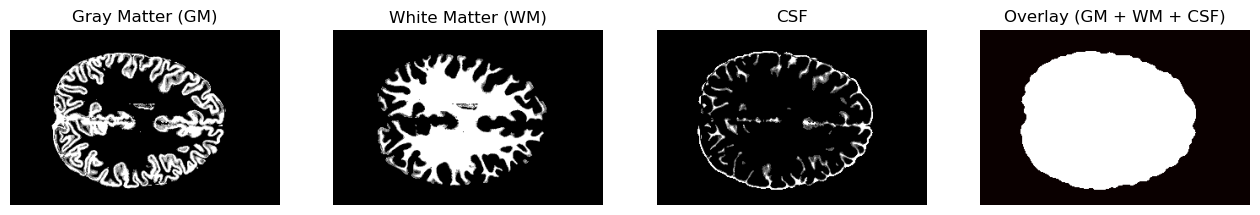

In [7]:
# Select the middle slice for visualization
slice_idx = gm_img.shape[2] // 2  

# Plot each tissue type
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Gray Matter
axes[0].imshow(gm_img[:, :, slice_idx], cmap="gray")
axes[0].set_title("Gray Matter (GM)")
axes[0].axis("off")

# White Matter
axes[1].imshow(wm_img[:, :, slice_idx], cmap="gray")
axes[1].set_title("White Matter (WM)")
axes[1].axis("off")

# Cerebrospinal Fluid
axes[2].imshow(csf_img[:, :, slice_idx], cmap="gray")
axes[2].set_title("CSF")
axes[2].axis("off")

# Overlay all tissues on the same plot
overlay = gm_img[:, :, slice_idx] + wm_img[:, :, slice_idx] + csf_img[:, :, slice_idx]
axes[3].imshow(overlay, cmap="hot")
axes[3].set_title("Overlay (GM + WM + CSF)")
axes[3].axis("off")

plt.show()


In [13]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Path to OpenNeuro dataset
data_dir = r"C:\Users\goud3\OneDrive\Documents\data\OpenNeuro_Filtered"

# Find the segmentation and MRI files
mri_file = next((f for f in os.listdir(data_dir) if f.endswith(".nii") and "T1w" in f), None)  # Example: T1-weighted MRI
gm_file = next((f for f in os.listdir(data_dir) if f.endswith("label-GM_probseg.nii")), None)
wm_file = next((f for f in os.listdir(data_dir) if f.endswith("label-WM_probseg.nii")), None)
csf_file = next((f for f in os.listdir(data_dir) if f.endswith("label-CSF_probseg.nii")), None)

if not all([mri_file, gm_file, wm_file, csf_file]):
    print("Error: Missing MRI or segmentation files.")
    exit()

# Load the NIfTI images
mri_path = os.path.join(data_dir, mri_file)
gm_path = os.path.join(data_dir, gm_file)
wm_path = os.path.join(data_dir, wm_file)
csf_path = os.path.join(data_dir, csf_file)

mri_img = nib.load(mri_path).get_fdata()
gm_img = nib.load(gm_path).get_fdata()
wm_img = nib.load(wm_path).get_fdata()
csf_img = nib.load(csf_path).get_fdata()


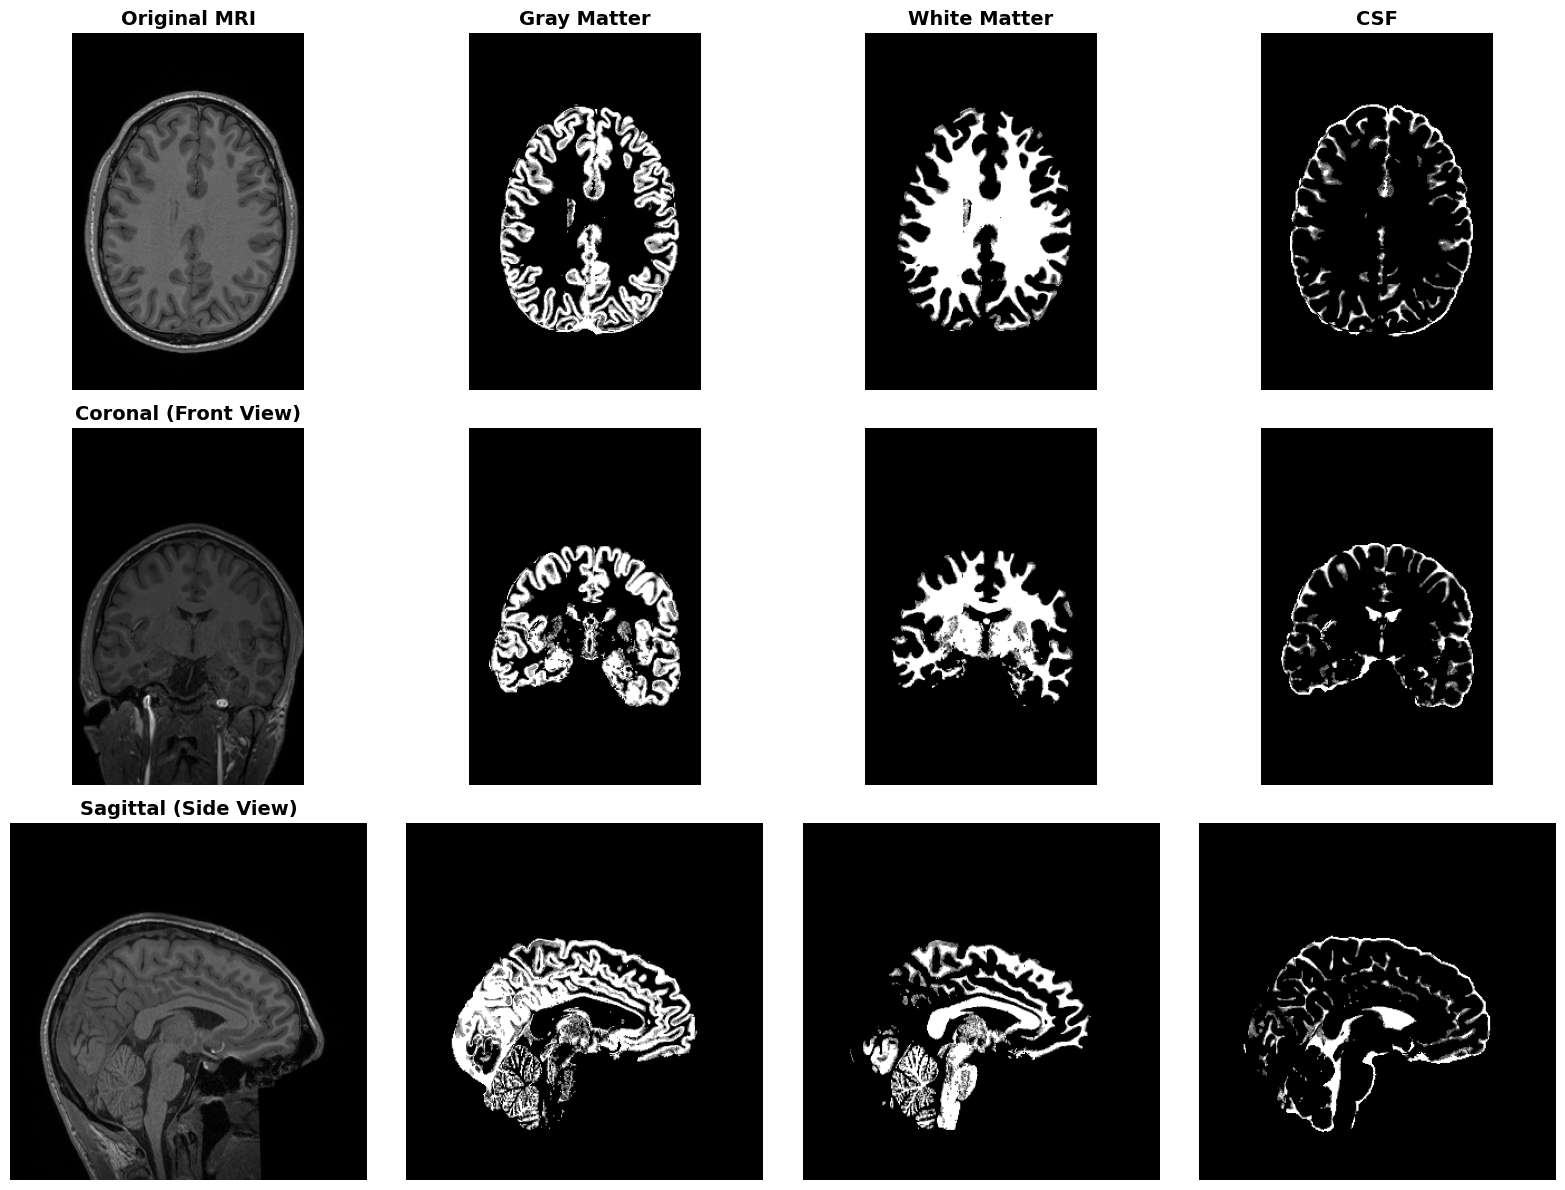

In [14]:
# Get the middle slices
axial_idx = mri_img.shape[2] // 2       # Axial (Top-Down)
coronal_idx = mri_img.shape[1] // 2     # Coronal (Front View)
sagittal_idx = mri_img.shape[0] // 2    # Sagittal (Side View)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Titles for each row
plane_titles = ["Axial (Top-Down)", "Coronal (Front View)", "Sagittal (Side View)"]
segment_titles = ["Original MRI", "Gray Matter", "White Matter", "CSF"]

# Function to get slices from all views
def get_slices(img):
    return img[:, :, axial_idx], img[:, coronal_idx, :], img[sagittal_idx, :, :]

# Get slices for MRI and segmentations
mri_slices = get_slices(mri_img)
gm_slices = get_slices(gm_img)
wm_slices = get_slices(wm_img)
csf_slices = get_slices(csf_img)

# Plot each slice
for i, slices in enumerate([mri_slices, gm_slices, wm_slices, csf_slices]):
    for j, slice_data in enumerate(slices):
        axes[j, i].imshow(slice_data.T, cmap="gray", origin="lower")
        if i == 0:
            axes[j, i].set_title(plane_titles[j], fontsize=14, fontweight="bold")
        if j == 0:
            axes[j, i].set_title(segment_titles[i], fontsize=14, fontweight="bold")
        axes[j, i].axis("off")

plt.tight_layout()
plt.show()


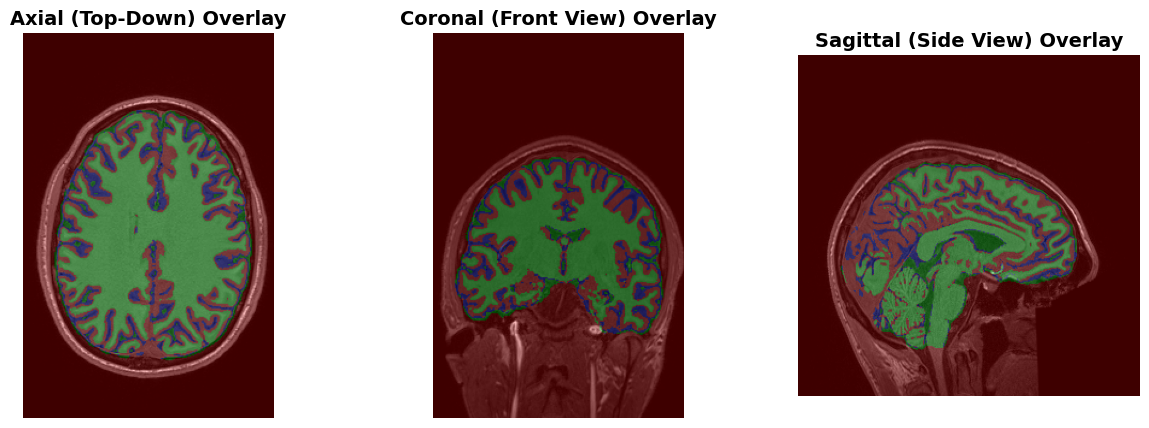

In [15]:
import matplotlib.colors as mcolors

# Define colormap (Red = GM, Green = WM, Blue = CSF)
colors = [(1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)]  # RGBA (Alpha=0.5 for transparency)
cmap = mcolors.ListedColormap(colors)

# Create combined segmentation mask (0 = Background, 1 = GM, 2 = WM, 3 = CSF)
segmentation_combined = (gm_img > 0).astype(int) + (wm_img > 0).astype(int) * 2 + (csf_img > 0).astype(int) * 3

# Get overlay slices
overlay_slices = get_slices(segmentation_combined)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, slice_data in enumerate(overlay_slices):
    axes[i].imshow(mri_slices[i].T, cmap="gray", origin="lower")
    axes[i].imshow(slice_data.T, cmap=cmap, origin="lower", alpha=0.5)
    axes[i].set_title(f"{plane_titles[i]} Overlay", fontsize=14, fontweight="bold")
    axes[i].axis("off")

plt.show()


In [17]:
import numpy as np

# Calculate the total number of voxels for each tissue type
total_voxels = np.prod(gm_img.shape)
gm_volume = np.sum(gm_img > 0) / total_voxels
wm_volume = np.sum(wm_img > 0) / total_voxels
csf_volume = np.sum(csf_img > 0) / total_voxels

# Print volume distribution
print(f"Gray Matter Volume: {gm_volume * 100:.2f}%")
print(f"White Matter Volume: {wm_volume * 100:.2f}%")
print(f"Cerebrospinal Fluid Volume: {csf_volume * 100:.2f}%")


Gray Matter Volume: 9.13%
White Matter Volume: 7.66%
Cerebrospinal Fluid Volume: 3.40%


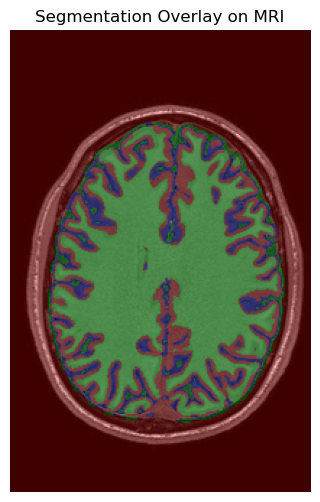

In [19]:
import matplotlib.colors as mcolors

# Define colormap (Red = GM, Green = WM, Blue = CSF)
colors = [(1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)]  # RGBA (Alpha=0.5 for transparency)
cmap = mcolors.ListedColormap(colors)

# Create combined segmentation mask
segmentation_combined = (gm_img > 0).astype(int) + (wm_img > 0).astype(int) * 2 + (csf_img > 0).astype(int) * 3

# Get slices
slice_idx = mri_img.shape[2] // 2
mri_slice = mri_img[:, :, slice_idx]
seg_slice = segmentation_combined[:, :, slice_idx]

# Plot MRI with segmentation overlay
plt.figure(figsize=(8, 6))
plt.imshow(mri_slice.T, cmap="gray", origin="lower")
plt.imshow(seg_slice.T, cmap=cmap, origin="lower", alpha=0.5)
plt.title("Segmentation Overlay on MRI")
plt.axis("off")
plt.show()


In [22]:
import os
import nibabel as nib
import numpy as np
import torch
import monai
from monai.transforms import (
    LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
)
import matplotlib.pyplot as plt

# Load the MRI scan
mri_path = "C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered/sub-03_desc-preproc_T1w.nii"

img = nib.load(mri_path).get_fdata()

# Normalize intensity for better model performance
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# Convert to PyTorch tensor
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch & channel dims
print("MRI Shape:", img_tensor.shape)  # Expected: (1, 1, H, W, D)


MRI Shape: torch.Size([1, 1, 208, 320, 320])


In [24]:
print("Total MRI scans found:", len(mri_files))
print("Total GM masks found:", len(gm_files))
print("Total WM masks found:", len(wm_files))
print("Total CSF masks found:", len(csf_files))

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))


Total MRI scans found: 0
Total GM masks found: 6
Total WM masks found: 6
Total CSF masks found: 6
Train set size: 0
Validation set size: 0


In [25]:
import os

data_dir = "C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered/"

# List all files in the dataset directory
all_files = os.listdir(data_dir)
print("All files in directory:", all_files)


All files in directory: ['images', 'masks', 'sub-03_desc-preproc_T1w.nii', 'sub-03_dseg.nii', 'sub-03_label-CSF_probseg.nii', 'sub-03_label-CSF_probseg.nii.gz', 'sub-03_label-GM_probseg.nii', 'sub-03_label-GM_probseg.nii.gz', 'sub-03_label-WM_probseg.nii', 'sub-03_label-WM_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii', 'sub-03_space-MNI152NLin2009cAsym_dseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz', 'sub-03_space-MNI152NLin2009cAsym_label-WM_probseg.nii', 'sub-03_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz', 'sub-05_desc-preproc_T1w.nii', 'sub-05_dseg.nii', 'sub-05_label-CSF_probseg.nii', 'sub-05_label-CSF_probseg.nii.gz', 'sub-05_label-GM_probseg.nii', 'sub-05_label-GM_probseg.nii.gz', 'sub-05_label-WM_probseg.nii', 'sub-05_label-WM_probseg.nii.gz', 'sub-05

In [26]:
import glob

mri_files = sorted(glob.glob(os.path.join(data_dir, "*T1w*")))
print("MRI Files Found:", mri_files)


MRI Files Found: ['C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_desc-preproc_T1w.nii', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-05_desc-preproc_T1w.nii', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-05_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-06_desc-preproc_T1w.nii', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-06_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii']


In [27]:
import os
import glob
import nibabel as nib
import numpy as np
import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, ToTensord
from monai.data import Dataset, DataLoader

# Path to OpenNeuro dataset
data_dir = "C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered/"

# Find all MRI scans and their segmentation masks
mri_files = sorted(glob.glob(os.path.join(data_dir, "*T1w.nii")))
gm_files = sorted(glob.glob(os.path.join(data_dir, "*label-GM_probseg.nii.gz")))
wm_files = sorted(glob.glob(os.path.join(data_dir, "*label-WM_probseg.nii.gz")))
csf_files = sorted(glob.glob(os.path.join(data_dir, "*label-CSF_probseg.nii.gz")))

# Create dataset dictionary
data_dicts = [{"image": img, "label": [gm, wm, csf]} for img, gm, wm, csf in zip(mri_files, gm_files, wm_files, csf_files)]

# Define transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-1, a_max=1, b_min=0, b_max=1, clip=True),
    ToTensord(keys=["image", "label"]),
])

# Split dataset into training & validation
train_data, val_data = data_dicts[:int(len(data_dicts)*0.8)], data_dicts[int(len(data_dicts)*0.8):]
train_ds = Dataset(data=train_data, transform=transforms)
val_ds = Dataset(data=val_data, transform=transforms)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2)


In [28]:
print("Total MRI scans found:", len(mri_files))
print("Total GM masks found:", len(gm_files))
print("Total WM masks found:", len(wm_files))
print("Total CSF masks found:", len(csf_files))


Total MRI scans found: 6
Total GM masks found: 6
Total WM masks found: 6
Total CSF masks found: 6


In [29]:
# Dictionary to store matched files
matched_data = []

for mri_path in mri_files:
    subject_id = os.path.basename(mri_path).split("_")[0]  # Extract subject ID (e.g., "sub-03")

    # Find corresponding segmentation masks
    gm_match = next((f for f in gm_files if subject_id in f), None)
    wm_match = next((f for f in wm_files if subject_id in f), None)
    csf_match = next((f for f in csf_files if subject_id in f), None)

    if gm_match and wm_match and csf_match:
        matched_data.append({"image": mri_path, "label": [gm_match, wm_match, csf_match]})

# Print how many matched subjects we found
print("✅ Matched MRI scans with segmentation masks:", len(matched_data))


✅ Matched MRI scans with segmentation masks: 6


In [30]:
import monai
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, ToTensord
from monai.data import Dataset, DataLoader

# Define transformations
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load MRI & segmentation masks
    EnsureChannelFirstd(keys=["image", "label"]),  # Add channel dimension
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1, b_min=0, b_max=1),  # Normalize MRI
    ToTensord(keys=["image", "label"])  # Convert to PyTorch tensor
])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(matched_data))
train_files, val_files = matched_data[:train_size], matched_data[train_size:]

# Create MONAI dataset
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=train_transforms)

# DataLoader for batching
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

# Check data shape
sample = next(iter(train_loader))
print("MRI Shape:", sample["image"].shape)
print("Segmentation Shape:", sample["label"].shape)


MRI Shape: torch.Size([1, 1, 241, 305, 257])
Segmentation Shape: torch.Size([1, 3, 208, 320, 320])


In [145]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, 
    Spacingd, ResizeWithPadOrCropd, ToTensord
)

# Define transformations with resizing
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load MRI & segmentation masks
    EnsureChannelFirstd(keys=["image", "label"]),  # Add channel dimension
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1, b_min=0, b_max=1),  # Normalize

    # Resample MRI to match segmentation mask size
    ResizeWithPadOrCropd(keys=["image"], spatial_size=(208, 320, 320)),

    ToTensord(keys=["image", "label"])  # Convert to PyTorch tensor
])

# Re-create dataset
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

# Check new MRI shape
sample = next(iter(train_loader))
print("Updated MRI Shape:", sample["image"].shape)
print("Updated Segmentation Shape:", sample["label"].shape)


Updated MRI Shape: torch.Size([1, 1, 208, 320, 320])
Updated Segmentation Shape: torch.Size([1, 3, 208, 320, 320])


In [146]:
for batch in train_loader:
    print(f"Image shape: {batch['image'].shape}")  # Expected: [B, 1, H, W, D]
    print(f"Label shape: {batch['label'].shape}")  # Expected: [B, 1, H, W, D] before one-hot encoding
    break  # Check one batch and exit


Image shape: torch.Size([1, 1, 208, 320, 320])
Label shape: torch.Size([1, 3, 208, 320, 320])


In [147]:
import numpy as np

# Load a sample label from your dataset
sample_label = train_ds[0]["label"].numpy()  # Get first label

# Find unique values in the label
unique_classes = np.unique(sample_label)
num_classes = len(unique_classes)

print("Unique values in label:", unique_classes)
print(f"Detected {num_classes} classes.")


Unique values in label: [0.0000000e+00 6.5565109e-07 9.9999998e-03 1.0000646e-02 2.0000000e-02
 2.0000637e-02 2.9999999e-02 3.0000627e-02 3.9999999e-02 4.0000618e-02
 5.0000001e-02 5.0000608e-02 6.0000002e-02 6.0000598e-02 7.0000000e-02
 7.0000589e-02 7.9999998e-02 8.0000579e-02 8.9999996e-02 9.0000570e-02
 9.9999994e-02 1.0000056e-01 1.0999999e-01 1.1000055e-01 1.1999999e-01
 1.2000054e-01 1.3000000e-01 1.3000053e-01 1.4000000e-01 1.4000052e-01
 1.5000001e-01 1.5000051e-01 1.6000001e-01 1.6000050e-01 1.7000002e-01
 1.7000049e-01 1.8000002e-01 1.8000048e-01 1.9000003e-01 1.9000047e-01
 2.0000003e-01 2.0000046e-01 2.1000004e-01 2.1000046e-01 2.2000004e-01
 2.2000045e-01 2.3000005e-01 2.3000044e-01 2.4000005e-01 2.4000043e-01
 2.5000006e-01 2.5000042e-01 2.6000005e-01 2.6000041e-01 2.7000004e-01
 2.7000040e-01 2.8000003e-01 2.8000039e-01 2.9000002e-01 2.9000038e-01
 3.0000001e-01 3.0000037e-01 3.1000000e-01 3.1000036e-01 3.1999999e-01
 3.2000035e-01 3.2999998e-01 3.3000034e-01 3.3999997e

In [148]:
for i in range(3):  # Checking first 3 samples
    sample = matched_data[i]  
    print(f"Sample {i}: {sample}")


Sample 0: {'image': 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_desc-preproc_T1w.nii', 'label': ['C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-GM_probseg.nii.gz', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-WM_probseg.nii.gz', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-CSF_probseg.nii.gz']}
Sample 1: {'image': 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii', 'label': ['C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-GM_probseg.nii.gz', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-WM_probseg.nii.gz', 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-03_label-CSF_probseg.nii.gz']}
Sample 2: {'image': 'C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Filtered\\sub-05_desc-preproc_T1w.nii', 'label': ['C:/Users/goud3/OneDrive/Documents/data/OpenNeuro_Fi

In [149]:
num_classes = 202  # Define the number of segmentation classes


In [150]:
for i, data in enumerate(train_loader.dataset):
    print(f"Image {i} shape: {data['image'].shape}, Label shape: {data['label'].shape}")


Image 0 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 1 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 2 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 3 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])


In [151]:
from monai.transforms import LoadImaged, EnsureChannelFirstd, Spacingd, Compose, Lambda
import numpy as np

def convert_label_to_single_channel(data):
    print(f"Before: Label shape {data['label'].shape}")  # Debugging
    if isinstance(data["label"], np.ndarray):  # Ensure it's NumPy
        data["label"] = np.expand_dims(data["label"][0], axis=0)  # Keep only first channel, maintain shape
    print(f"After: Label shape {data['label'].shape}")  # Debugging
    return data

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambda(func=convert_label_to_single_channel),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
])


In [152]:
for i, data in enumerate(train_loader.dataset):
    print(f"Image {i} shape: {data['image'].shape}, Label shape: {data['label'].shape}")


Image 0 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 1 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 2 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 3 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])


In [153]:
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, EnsureTyped, AsDiscreted, SelectItemsd, Lambda
)
from monai.data import Dataset
from monai.transforms import Compose

keys = ["image", "label"]

train_transforms = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=["image"]),  # Ensure channel is first for images only
    EnsureTyped(keys=keys),

    # 🔹 Debugging print before fixing label channels
    Lambda(lambda x: print(f"Before Fix: Image {x['image'].shape}, Label {x['label'].shape}")),

    # ✅ Fix: Convert label to single-channel by taking first channel
    Lambda(lambda x: {**x, "label": x["label"][0:1]}),

    # 🔹 Debugging print after fixing label channels
    Lambda(lambda x: print(f"After Fix: Image {x['image'].shape}, Label {x['label'].shape}")),

    Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=keys, axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-1, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=keys, source_key="image", allow_smaller=True),

    # Convert label to discrete values (if needed)
    AsDiscreted(keys=["label"], threshold=0.5),
])

# Apply transforms to dataset
train_ds = Dataset(data=train_files, transform=train_transforms)


In [154]:
for i, data in enumerate(train_loader.dataset):
    print(f"Image {i} shape: {data['image'].shape}, Label shape: {data['label'].shape}")


Image 0 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 1 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 2 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])
Image 3 shape: torch.Size([1, 208, 320, 320]), Label shape: torch.Size([3, 208, 320, 320])


In [155]:
import torch
import monai
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    ResizeWithPadOrCropd, NormalizeIntensityd, AsDiscreted, ToTensord, Lambdad
)
from monai.data import Dataset, DataLoader
from monai.metrics import DiceMetric 
import matplotlib.pyplot as plt

# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




train_transforms = Compose([
    LoadImaged(keys=["image", "label"], ensure_channel_first=True),  # 🔹 Load images first
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys=["image", "label"], func=lambda x: print(f"Before Spacing: {x.shape}") or x),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(129, 153, 97)),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    AsDiscreted(keys=["label"], to_onehot=202),  # Fix: Removed `argmax=True`
    ToTensord(keys=["image", "label"])
])





# ✅ Split data into train & validation sets
train_size = int(0.8 * len(matched_data))
train_files, val_files = matched_data[:train_size], matched_data[train_size:]

# ✅ Create datasets & dataloaders
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

# ✅ Define 3D U-Net model
model = UNet(
    spatial_dims=3,
    in_channels=1,  # MRI input
    out_channels=3,  # 3 segmentation labels (GM, WM, CSF)
    channels=(16, 32, 64, 128, 256),  # U-Net layers
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# ✅ Loss function & optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Learning rate: 0.0001

# ✅ Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

# ✅ Dice Score Metric
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [156]:
print(f"Using {num_classes} segmentation classes.")


Using 202 segmentation classes.
